# OLIMPIJSKE MEDALJE

Avtorji: Andrej Skočir, Anton Martin Turk, Miha Kavs

Šolsko leto: 2023/24

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('podatki/olympic_medals.csv')

### 1. Koliko različnih disciplin je bilo skozi leta?

In [19]:
stevilo_disciplin = df['Discipline'].nunique()
print("Število razičnih disciplin:", stevilo_disciplin)

Število razičnih disciplin: 82


Koliko od teh je na poletni izvedbi in koliko na zimski?

In [18]:
# Preštejemo število edinstvenih disciplin za poletne igre
stevilo_poletnih_disciplin = df[df['Olympic_season'] == 'summer']['Discipline'].nunique()

# Preštejemo število edinstvenih disciplin za zimske igre
stevilo_zimskih_disciplin = df[df['Olympic_season'] == 'winter']['Discipline'].nunique()

print("Poletne:", stevilo_poletnih_disciplin)
print("Zimske:", stevilo_zimskih_disciplin)
print("Skupaj:", stevilo_poletnih_disciplin + stevilo_zimskih_disciplin)

Poletne: 68
Zimske: 17
Skupaj: 85


Če smo pozorni opazimo nekaj čudnega. Zgoraj smo dobili rezultat 82 različnih disciplin tukaj pa 68 poletnih in 17 zimskih kar se sešteje v 85. Zakaj nastane ta razlika treh disciplin?</br>
Poglejmo če so se kakšne discipline pojavile tako na poletnih in zimskih igrah.

In [10]:
# Izberemo discipline samo za poletne igre
poletne_discipline = set(df[df['Olympic_season'] == 'summer']['Discipline'].unique())

# Izberemo discipline samo za zimske igre
zimske_discipline = set(df[df['Olympic_season'] == 'winter']['Discipline'].unique())

# Poiščemo presek med množico disciplin za poletne in zimske igre
discipline_v_obeh = poletne_discipline.intersection(zimske_discipline)
discipline_v_obeh

{'Alpinism', 'Figure Skating', 'Ice Hockey'}

Alpinizem, umetnostno drsanje in hokej na ledu so takšne discipline, ki so se pojavile na obeh izvedbah.</br> Poglejmo si en primer:

In [14]:
# Izberemo primere, ki vsebujejo discipline, ki se pojavljajo tako na poletnih kot tudi na zimskih igrah
primeri_v_obeh = df[df['Discipline']== 'Ice Hockey']
primeri_v_obeh.head(6)

,Olympiad,Discipline,Event,Winner,Medal_type,Olympic_city,Olympic_year,Olympic_season,Gender,Code,Committee,Committee_type
1568,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",Czechoslovakia,Bronze,Antwerp,1920,summer,Men,TCH,Czechoslovakia,Former committee
1569,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",Canada,Gold,Antwerp,1920,summer,Men,CAN,Canada,Country
1570,Antwerpen 1920,Ice Hockey,"Ice Hockey, Men",United States,Silver,Antwerp,1920,summer,Men,USA,United States,Country
16938,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",Great Britain,Bronze,Chamonix,1924,winter,Men,GBR,Great Britain,Country
16939,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",Canada,Gold,Chamonix,1924,winter,Men,CAN,Canada,Country
16940,Chamonix 1924,Ice Hockey,"Ice Hockey, Men",United States,Silver,Chamonix,1924,winter,Men,USA,United States,Country


Kot lahko sami opazite, stolpec 'Discipline' je v vseh primerih 'Ice Hockey', medtem ko je stolpec 'Olympic_season' v treh zapisih 'summer', v treh pa 'winter'.

### 2. Število tekmovanj glede na disciplino

In [31]:
# Preštejemo število tekmovanj glede na disciplino
tekmovanja_glede_na_disciplino = df['Discipline'].value_counts()

print("Število tekmovanj glede na disciplino:")
print(tekmovanja_glede_na_disciplino)

Število tekmovanj glede na disciplino:
Discipline
Athletics              3082
Swimming               1762
Wrestling              1356
Artistic Gymnastics    1010
Boxing                  996
                       ... 
Equestrian Driving        3
Motorboating              3
Cricket                   2
Aeronautics               1
Basque pelota             1
Name: count, Length: 82, dtype: int64


Ker je disciplin 82, si je težko podatke predstavljati tekstovno.</br>
Zato si poglejmo histogram:

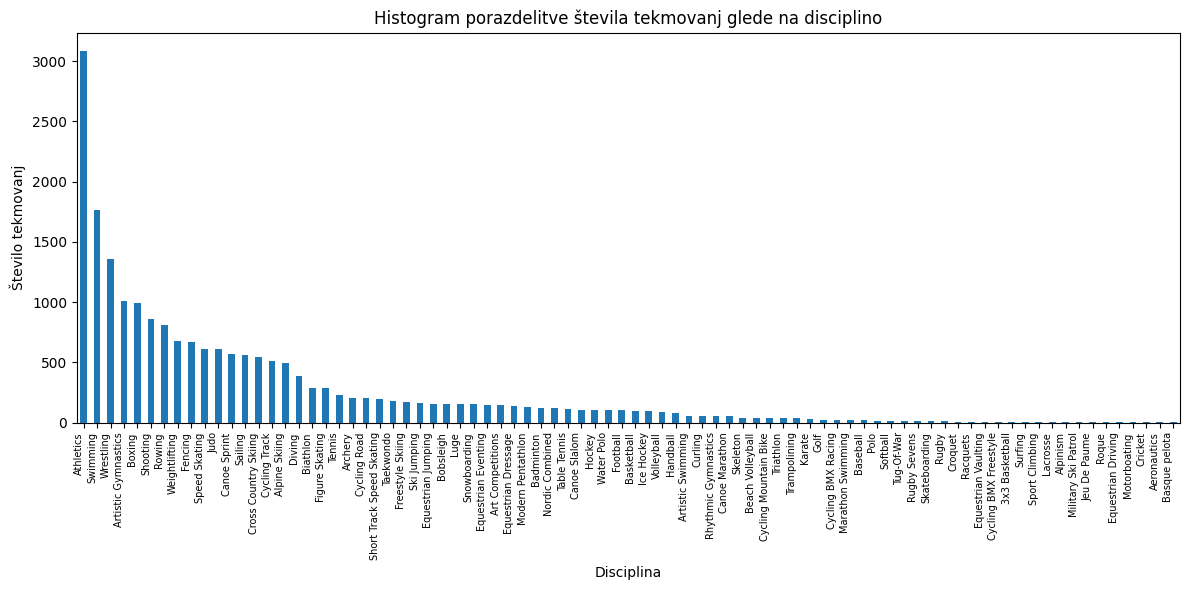

In [30]:
# Narišemo histogram porazdelitve
plt.figure(figsize=(12, 6))
tekmovanja_glede_na_disciplino.plot(kind='bar')
plt.title('Histogram porazdelitve števila tekmovanj glede na disciplino')
plt.xlabel('Disciplina')
plt.ylabel('Število tekmovanj')
plt.xticks(ha='right', fontsize=7)
plt.tight_layout()
plt.show()

Opazimo, da ima atletika daleč največ tekmovanj na disciplino, kar čez 3000, naslednje je plavanje in nato rokoborba.

### 3. Najuspešnejše države v ekipnih tekmovanjih

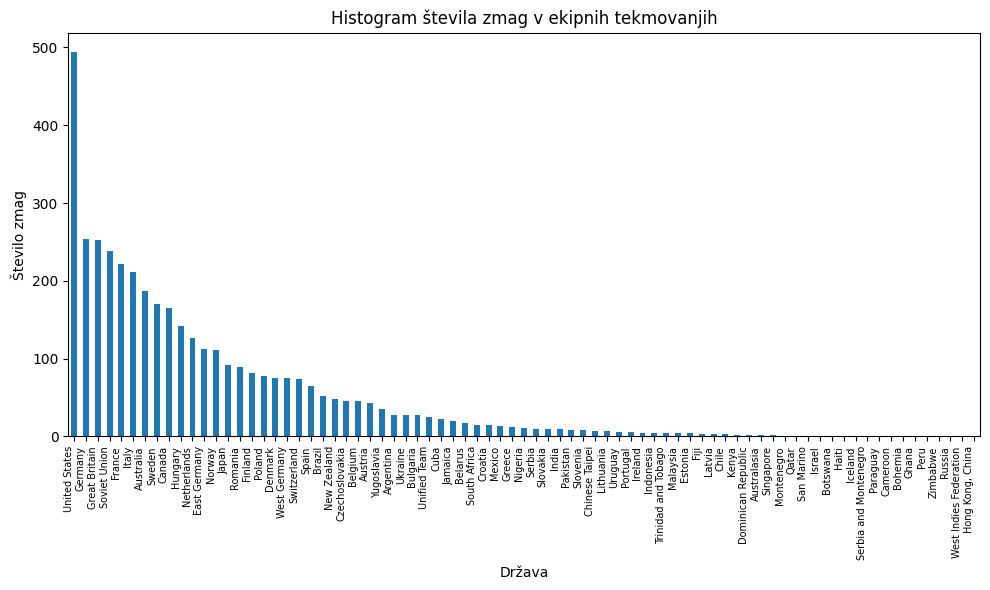

In [44]:
# Preverimo, kje je v stolpcu "Winner" navedeno ime države
ekipna_tekmovanja = df[df['Winner'] == df['Committee']]

# Preštejemo število zmag glede na državo
stevilo_zmag_na_drzavo = ekipna_tekmovanja['Winner'].value_counts()

# Narišemo histogram porazdelitve
plt.figure(figsize=(10, 6))
stevilo_zmag_na_drzavo.plot(kind='bar')
plt.title('Histogram števila zmag v ekipnih tekmovanjih')
plt.xlabel('Država')
plt.ylabel('Število zmag')
plt.xticks(ha='right', fontsize=7)
plt.tight_layout()
plt.show()

Opazimo, da so skoraj za 2x najboljše Zvezne države Amerike, pred Nemčijo in Združenim kraljestvom.

### 4. Najuspešnejši športnik

Tukaj bomo izključili vse ekipne discipline, tako da bomo dobili določenega posameznika.

In [117]:
# Določimo seznam zmagovalcev
zmagovalci = df['Winner'].unique()

# Določimo seznam držav iz stolpca "Committee"
drzave = df['Committee'].unique()

# Izločimo zmagovalce, katerih imena vsebujejo podniz, in če se ta podniz pojavi nekje v imenih držav iz stolpca "Committee"
izloceni_zmagovalci = []

for zmagovalec in zmagovalci:
    for drzava in drzave:
        for beseda in drzava.split():
            if beseda in zmagovalec.split():
                izloceni_zmagovalci.append(zmagovalec)
                break
                
# Izberemo samo tiste vrstice, kjer zmagovalci niso v seznamu izlocenih zmagovalcev
zmagovalci_brez_podniza = df[~df['Winner'].isin(izloceni_zmagovalci)]

# Izračunamo število osvojenih medalj za vsakega zmagovalca
stevilo_medalj_na_zmagovalca = zmagovalci_brez_podniza['Winner'].value_counts()
print("Najuspešnejši olimpijec: ", stevilo_medalj_na_zmagovalca.idxmax())

Najuspešnejši olimpijec:  Michael Phelps


Najuspešnejši olimpijec vseh časov je torej znani plavalec Michael Phelps.